In [96]:
from fktools import *
import tensorflow as tf
import sklearn

In [97]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(8,)),
            tf.keras.layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(8, activation='softmax'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


latent_dim = 2
autoencoder = Autoencoder(latent_dim)

In [98]:
X = np.load("dataset_denoising_multiple_X.npz")['arr_0']
y = np.load("dataset_denoising_multiple_y.npz")['arr_0']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

print(f"X train size: {X_train.shape}")
print(f"X test size: {X_test.shape}")

X shape: (58711, 8)
y shape: (58711, 8)
X train size: (46968, 8)
X test size: (11743, 8)


In [99]:
autoencoder.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='kld',
    metrics=['acc']
)

history = autoencoder.fit(
    y_train, y_train,
    epochs=20,
    batch_size=64,
    # validation_split=0.2
)

Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.2466 - loss: 0.7816 
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - acc: 0.4364 - loss: 0.4106
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - acc: 0.5012 - loss: 0.3043
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - acc: 0.6000 - loss: 0.2622
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - acc: 0.6382 - loss: 0.2178
Epoch 6/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - acc: 0.7101 - loss: 0.1775
Epoch 7/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - acc: 0.7667 - loss: 0.1516
Epoch 8/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - acc: 0.8091 - loss: 0.1305
Epoch 9/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - acc: 0.8240 - loss: 0.1136
Epoch 10/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - acc: 0.8344 - loss: 0.1008
Epoch 11/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.8465 - loss: 0.0910  
Epoch 12/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - acc: 0.8581 - loss: 0.0837
Ep

In [100]:
loss = history.history['loss']
acc = history.history['acc']

epochs = range(1, len(loss) + 1)

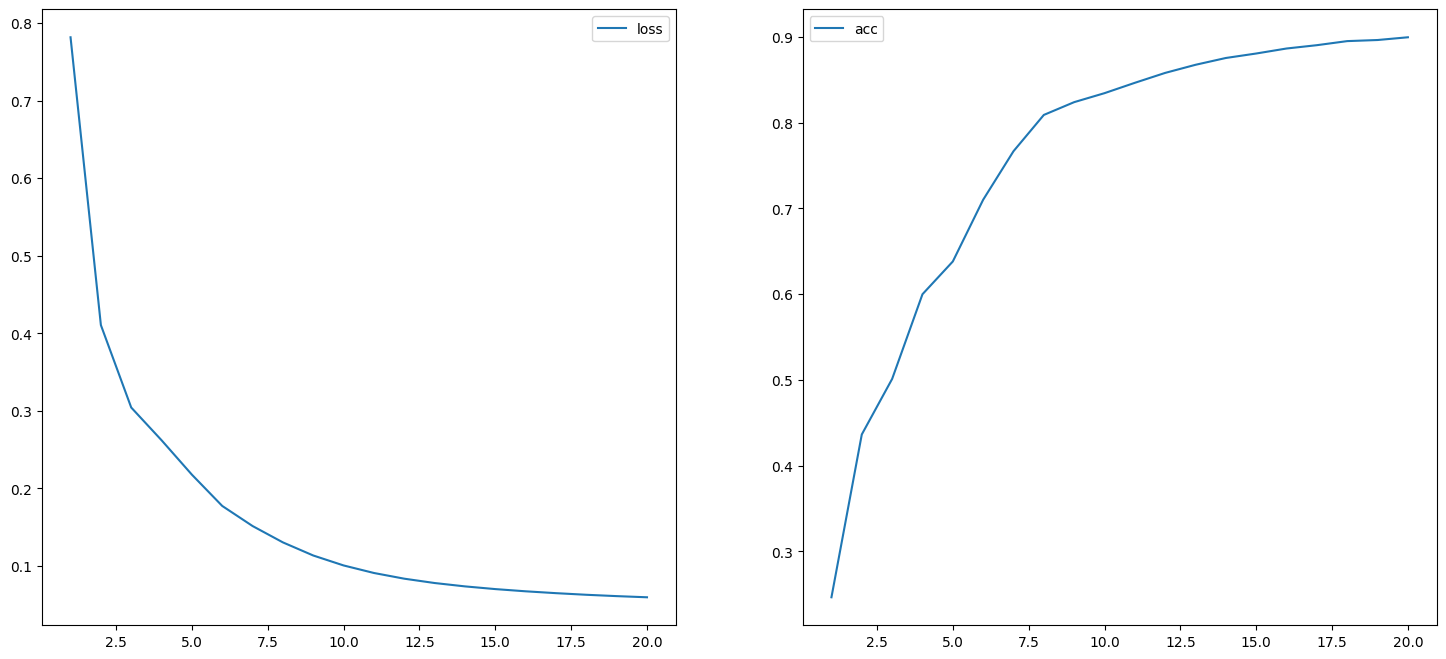

In [101]:
fig, ax = plt.subplots(ncols=2, figsize=(18,8))
ax[0].plot(epochs, loss, label="loss")
ax[0].legend()
ax[1].plot(epochs, acc, label="acc")
ax[1].legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


<BarContainer object of 8 artists>

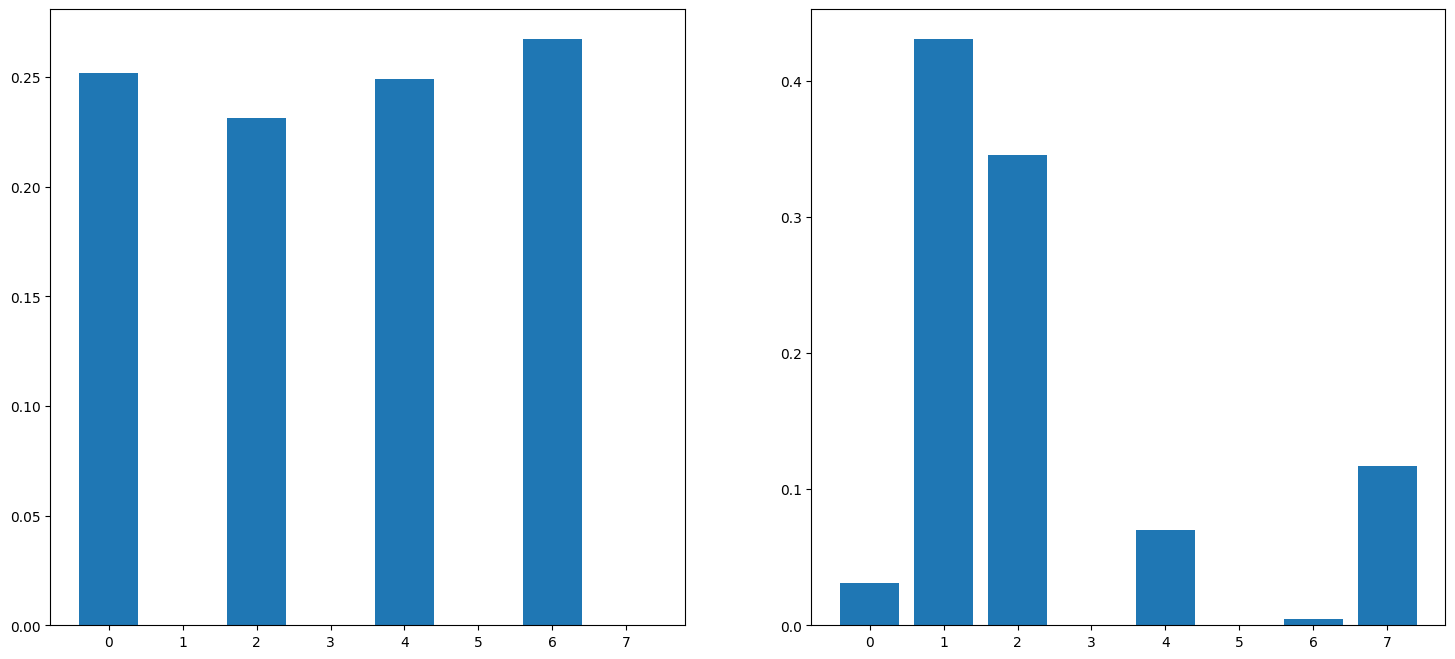

In [102]:
i = 2

pred = autoencoder.predict(np.array([X[i]]))[0]

fig, ax = plt.subplots(ncols=2, figsize=(18,8))

ax[0].bar(np.arange(8), y_test[i])
ax[1].bar(np.arange(8), pred)

[[0.4138329  0.2997508 ]
 [2.988713   4.8293858 ]
 [0.26124442 0.48523784]
 ...
 [2.7780385  4.167282  ]
 [0.5145304  0.10137033]
 [0.79574883 0.21635842]]


Text(0.5, 1.0, 'autoencoder 8-2-8, encoded points, wihout noise')

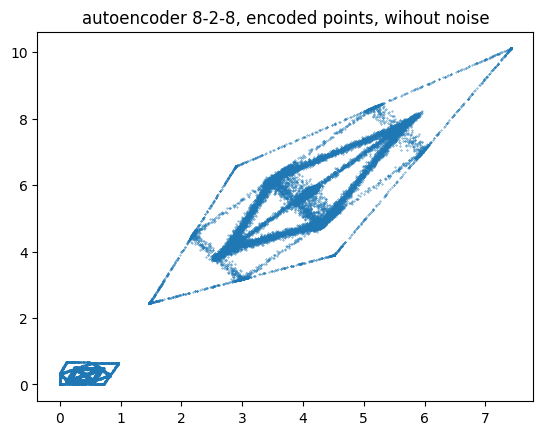

In [105]:
encoded_points = np.array(autoencoder.encoder(y))

print(encoded_points)

plt.scatter(encoded_points[:,0], encoded_points[:,1],s=0.1)
plt.title("autoencoder 8-2-8, encoded points, wihout noise")